In [1]:
import Pkg
Pkg.status(["Agents", "CairoMakie", "GLMakie", "InteractiveDynamics"])

Status `~/Documents/Research/Jurgen/History_Chemistry/ABM_Chemistry/Project.toml`
  [46ada45e] Agents v5.14.0
  [13f3f980] CairoMakie v0.10.4
  [e9467ef8] GLMakie v0.8.4
  [ec714cd0] InteractiveDynamics v0.22.1


In [2]:
using Agents
using CairoMakie

## 1. Choose the space
Agents live in a 2D grid.

In [15]:
space = GridSpace((25,25))

GridSpace with size (25, 25), metric=chebyshev, periodic=true

## 2. Define the agent type

The agents are of type **author**. Each author has the following property:
* `num_publications`: authors need a `min_neighbours_to_publish`. If their reputation is high enough they will successfully publish.
* `num_citations`: it models reputation, the higher this quantity, the higher is the reputation. 

Reputation models the probability to publish and it is based on citations. reputation = author.num_citations / total_num_citations


In [25]:
@agent Author GridAgent{2} begin
    num_citations::Int64
    num_publications::Int64
end

In [26]:
for (name, type) in zip(fieldnames(Author), fieldtypes(Author))
    println(name, "::", type)
end

id::Int64
pos::Tuple{Int64, Int64}
num_citations::Int64
num_publications::Int64


## 3. Define the model

In [27]:
model = AgentBasedModel(Author, space)

StandardABM with 0 agents of type Author
 space: GridSpace with size (25, 25), metric=chebyshev, periodic=true
 scheduler: fastest

In [28]:
using Random: Xoshiro #reproducibility

function initialise(; 
    total_agents = 100, 
    griddims = (25, 25),
    num_citations = rand(rng,1:5),
    num_publications = 0,
    min_neighbours_to_publish = 2,
    seed = 1234,
)

space = GridSpace(griddims)
rng = Xoshiro(seed)

#properties
properties = Dict(:min_neighbours_to_publish => min_neighbours_to_publish)

model = AgentBasedModel(Author, space; rng, properties)

for n in 1:total_agents
    add_agent!(model, num_citations, num_publications)
end
return model
end

model = initialise()

StandardABM with 100 agents of type Author
 space: GridSpace with size (25, 25), metric=chebyshev, periodic=true
 scheduler: fastest
 properties: min_neighbours_to_publish

## 4. Time evolution of the ABM

In [29]:
function author_step!(author, model)
    randomwalk!(author, model, 1)# radius 1

    #count number neighbours
    count_neighbours = 0
    
    for i in nearby_agents(author, model)
        count_neighbours += 1
    end

    #Condition to publish
    if count_neighbours ≥ model.min_neighbours_to_publish
        reputation = author.num_citations/total_citations(model)
        if rand(rng) < reputation
            author.num_publications +=1
        end
    end

    #Condition to increase citations
    if author.num_publications > 10
        author.num_citations +=1
    end
end
   

author_step! (generic function with 1 method)

In [30]:
function total_citations(model)
    total_citations = 0
    for agent in allagents(model)
        total_citations = sum(agent.num_citations)
    end
    return total_citations
end

total_citations (generic function with 1 method)

## 5. Collect data

In [31]:
model = initialise()

adata = [(:num_citations,sum), (:num_publications,sum)]

data_agents, _ = run!(model, author_step!, 100; adata)
data_agents

Row,step,sum_num_citations,sum_num_publications
,Int64,Int64,Int64
1,0,100,0
2,1,100,38
3,2,100,75
4,3,100,113
5,4,100,151
6,5,100,196
7,6,100,236
8,7,100,269
9,8,100,309


## 6. Visualise data

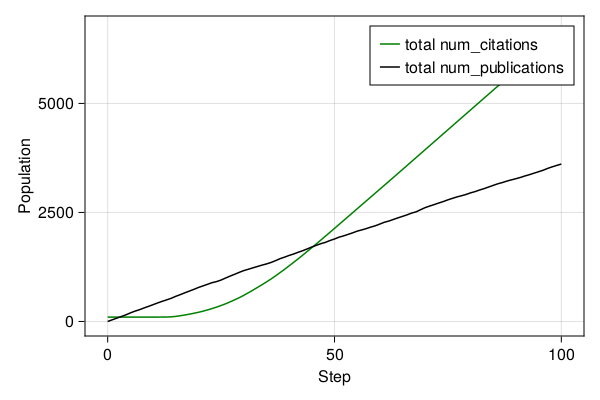

In [32]:

function plot_data_authors(data)

    figure = Figure(resolution = (600, 400))
    ax = figure[1, 1] = Axis(figure; xlabel = "Step", ylabel = "Population")

    lines!(ax, data.step, data.sum_num_citations, color = :green, label = "total num_citations")
    lines!(ax, data.step, data.sum_num_publications, color = :black, label = "total num_publications")
    axislegend(ax)
    figure
end

plot_data_authors(data_agents)